# <center> M2MO - XVA Project

In [416]:
import  torch
import  torch.nn                as      nn
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm
from    sklearn.linear_model    import  LinearRegression
from    tqdm                    import  tqdm

In [417]:
r       = 0.02
S0      = 100
kappa   = 0.12
sigma   = 0.2
h       = 0.25
T       = 5
delta   = 1/52

def beta(t):
    return np.exp(-r*t)

In [460]:
dt                      = delta
time_grid               = np.arange(0, T+dt, dt)
N                       = len(time_grid)-1
swap_grid               = np.arange(0, T+h, h) # np.array([0, 2.5, 5])
d                       = len(swap_grid)-1

map_time_to_swap_inds   = np.searchsorted(swap_grid, time_grid, side='right') # l_{t} for t in time_grid
map_swap_to_time_inds   = np.where(np.isin(time_grid, swap_grid))[0] # indices of T_{l} in time_grid

Sbar                    = S0 * np.sum(beta(swap_grid[1:]) * np.exp(kappa*swap_grid[:-1])) / np.sum(beta(swap_grid[1:]))  
nom                     = 10**4 * beta(swap_grid[0]) / np.sum(beta(swap_grid[1:]))

M                       = 5000

## 0 - Utils

In [461]:
def generate_S(M):
    paths       = np.zeros((M, N+1))
    paths[:, 0] = S0
    Z           = np.random.normal(0, 1, size=(M, N))
    for i in range(1, N+1):
        paths[:, i] = paths[:, i-1] * np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*Z[:, i-1])
    return paths

In [462]:
def generate_MtM(S_paths):
    M   = S_paths.shape[0]
    MtM = np.zeros((M, N+1))
    for i in range(N):
        lt          = map_time_to_swap_inds[i]
        part_sum    = np.sum(beta(swap_grid[lt+1:])*(np.exp(kappa*(swap_grid[lt:-1] - time_grid[i]))*S_paths[:, i].reshape(-1, 1) - Sbar), axis=1)
        MtM[:, i]   = h*nom/beta(time_grid[i]) * (beta(swap_grid[lt])*(S_paths[:, map_swap_to_time_inds[lt-1]] - Sbar) + part_sum)
    return MtM

In [463]:
def f(i):
    lt_delta = map_time_to_swap_inds[i+1]
    return h * np.sum(beta(swap_grid[lt_delta+1:])*np.exp(kappa*(swap_grid[lt_delta:-1])))

def generate_MtM_gap(MtM_paths, S_paths):
    MtM_gap = np.zeros((M, N+1))
    for i in range(N):
        lt          = map_time_to_swap_inds[i]
        lt_delta    = map_time_to_swap_inds[i+1]
        Delta       = h/beta(time_grid[i+1]) * np.sum(beta(swap_grid[lt:lt_delta])*(S_paths[:, map_swap_to_time_inds[lt-1:lt_delta-1]].reshape(-1, 1) - Sbar), axis=1) if lt_delta>=lt+1 else 0
        MtM_gap[:, i] = np.maximum(beta(time_grid[i+1])*(MtM_paths[:, i+1] + Delta) - beta(time_grid[i])*MtM_paths[:, i], 0)
    return MtM_gap

def generate_MtM_gap_true(S_paths):
    MtM_gap = np.zeros_like(S_paths)
    for i in range(N):
        MtM_gap[:, i] = np.maximum(nom*f(i)*(np.exp(-kappa*time_grid[i+1])*S_paths[:, i+1]-np.exp(-kappa*time_grid[i])*S_paths[:, i]), 0)
    return MtM_gap

In [464]:
def A(i):
    return f(i) * (norm.cdf(sigma*np.sqrt(delta)/2) - norm.cdf(-sigma*np.sqrt(delta)/2))

def generate_expect_cond_MtM_gap(S_path):
    res         = np.zeros(N+1)
    beta_vals   = np.zeros(N+1)
    for i in range(N):
        beta_vals[i]    = nom * A(i) * np.exp(-kappa*time_grid[i])
        res[i]          = beta_vals[i] * S_path[i]
    return beta_vals, res

## I - CVA without RIM

In [465]:
S_paths                         = generate_S(M)

MtM_paths                       = generate_MtM(S_paths)

MtM_gap_paths                   = generate_MtM_gap(MtM_paths, S_paths)
MtM_gap_paths_true              = generate_MtM_gap_true(S_paths)

S_test_path                     = generate_S(1).reshape(-1) #np.repeat(S0, N+1)
beta_vals, expect_cond_MtM_gap  = generate_expect_cond_MtM_gap(S_test_path)

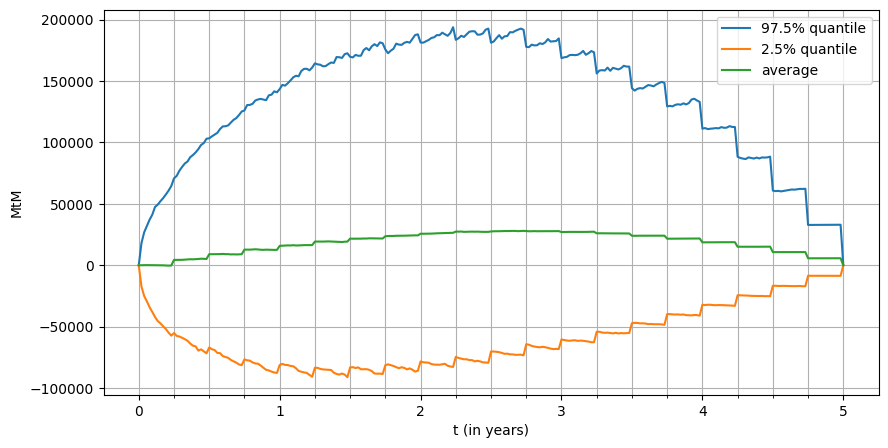

In [466]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_grid, np.quantile(MtM_paths, 0.975, axis=0), label='97.5% quantile') # ax.set
ax.plot(time_grid, np.quantile(MtM_paths, 0.025, axis=0), label='2.5% quantile')
ax.plot(time_grid, np.mean(MtM_paths, axis=0), label='average')
ax.set_xlabel('t (in years)')
ax.set_ylabel('MtM')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
plt.show()

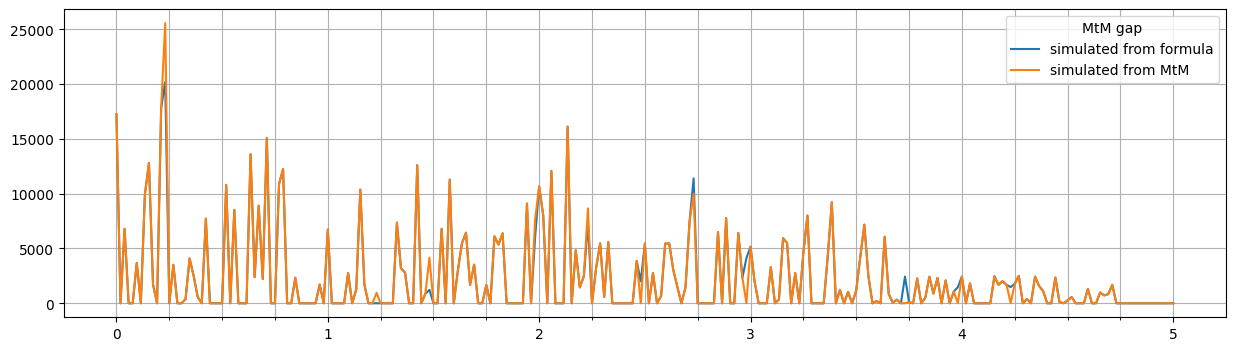

In [467]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(time_grid, MtM_gap_paths_true[2], label='simulated from formula')
ax.plot(time_grid, MtM_gap_paths[2], label='simulated from MtM')
ax.legend(title="MtM gap")
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
plt.show()

In [468]:
beta_vals_lr = np.zeros(N+1)
for i in range(N+1):
    model = LinearRegression(fit_intercept=False)
    model.fit(S_paths[:, i].reshape(-1, 1), MtM_gap_paths_true[:, i]) # MtM_gap_paths[:, i]
    beta_vals_lr[i] = model.coef_[0]

expect_cond_MtM_gap_lr = beta_vals_lr * S_test_path

In [469]:
class LinearRegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)
    def forward(self, x):
        return self.linear(x)

beta_vals_lnn = np.zeros(N+1)
for i in tqdm(range(N+1), desc='Fitting linear regression using neural network'):
    x           = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y           = torch.tensor(MtM_gap_paths_true[:, i].reshape(-1, 1), dtype=torch.float32) # MtM_gap_paths[:, i]
    model       = LinearRegressionNN()
    criterion   = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
    for epoch in range(400):
        model.train()
        optimizer.zero_grad()
        outputs = model(x)
        loss    = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    beta_vals_lnn[i] = model.linear.weight.item()

expect_cond_MtM_gap_lnn = beta_vals_lnn * S_test_path

Fitting linear regression using neural network: 100%|██████████| 261/261 [02:28<00:00,  1.76it/s]


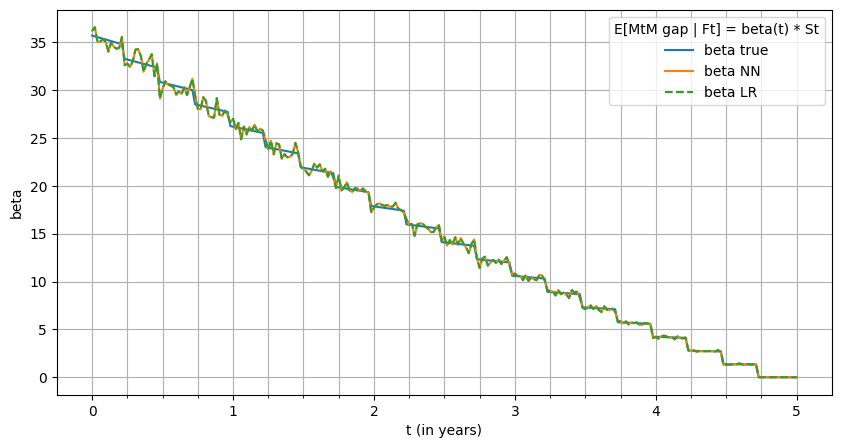

In [470]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_grid, beta_vals, label='beta true')
ax.plot(time_grid, beta_vals_lnn, label='beta NN')
ax.plot(time_grid, beta_vals_lr, '--', label='beta LR')
ax.set_xlabel('t (in years)')
ax.set_ylabel('beta')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend(title='E[MtM gap | Ft] = beta(t) * St')
plt.show()

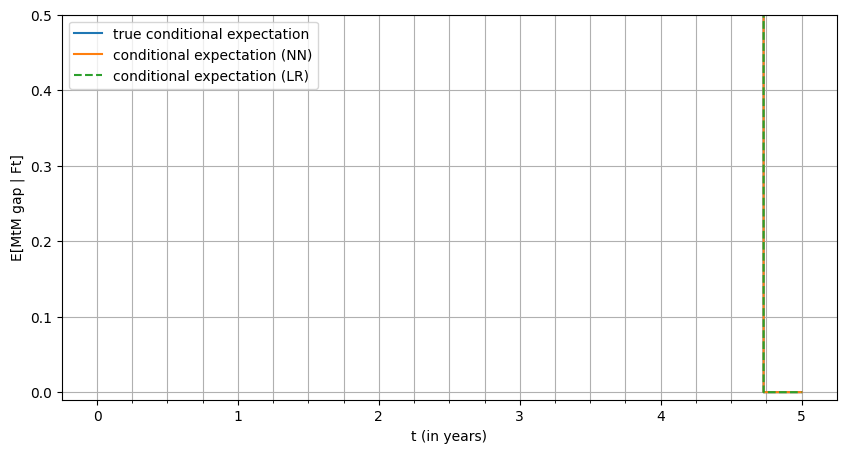

In [471]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_grid, expect_cond_MtM_gap, label='true conditional expectation')
ax.plot(time_grid, expect_cond_MtM_gap_lnn, label='conditional expectation (NN)')
ax.plot(time_grid, expect_cond_MtM_gap_lr, '--', label='conditional expectation (LR)')
ax.set_xlabel('t (in years)')
ax.set_ylabel('E[MtM gap | Ft]')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_ylim([-0.01, 0.5])
ax.legend()
plt.show()